In [1]:
from multiprocessing import Pool

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from scipy.stats import binomtest

In [2]:
mother, father = ['CAR2493_F', 'CAR2494_M']

samples_lst = pd.read_csv('./data/interim/samples.txt', header=None)[0].to_list()
print(samples_lst)

['CAR2463', 'CAR2464', 'CAR2465', 'CAR2466', 'CAR2467', 'CAR2468', 'CAR2469', 'CAR2470', 'CAR2471', 'CAR2472', 'CAR2473', 'CAR2474', 'CAR2475', 'CAR2476', 'CAR2477', 'CAR2478', 'CAR2479', 'CAR2480', 'CAR2481', 'CAR2482', 'CAR2483', 'CAR2484', 'CAR2485', 'CAR2486', 'CAR2487', 'CAR2488', 'CAR2489', 'CAR2490', 'CAR2491', 'CAR2492', 'CAR2493_F', 'CAR2494_M']


## Check mendelian by own filtering

#### Save in parquet

In [3]:
# 10min
# variants = pd.read_csv('./data/interim/bams/cohort.merged.table', sep='\t')
variants = pd.read_csv('./data/interim/cor/cohort.merged.table', sep='\t')
variants = variants[(variants.DP > 30) & (variants.QUAL > 30) & (variants.CHROM != 'NC_001606.1')]
variants[[x for x in variants.columns if x.endswith('.DP')]].median()

CAR2463.DP      16.0
CAR2464.DP      17.0
CAR2465.DP      16.0
CAR2466.DP      18.0
CAR2467.DP      17.0
CAR2468.DP      17.0
CAR2469.DP      15.0
CAR2470.DP      17.0
CAR2471.DP      15.0
CAR2472.DP      16.0
CAR2473.DP      15.0
CAR2474.DP      15.0
CAR2475.DP      14.0
CAR2476.DP      16.0
CAR2477.DP      17.0
CAR2478.DP      16.0
CAR2479.DP      15.0
CAR2480.DP      15.0
CAR2481.DP      16.0
CAR2482.DP      15.0
CAR2483.DP      15.0
CAR2484.DP      15.0
CAR2485.DP      13.0
CAR2486.DP      15.0
CAR2487.DP      16.0
CAR2488.DP      17.0
CAR2489.DP      17.0
CAR2490.DP      16.0
CAR2491.DP      16.0
CAR2492.DP      17.0
CAR2493_F.DP    17.0
CAR2494_M.DP    17.0
dtype: float64

In [8]:
#30min
for col in variants.columns:
    if col.endswith('.AD'):
        variants[col] = variants[col].apply(lambda x: [int(ad) for ad in x.split(',')])

In [9]:
variants.to_parquet('./data/interim/cor/cohort.merged.table.parquet')

#### check all vatiants QC

In [4]:
def filter_by_PL(pl: list):
    srted = sorted(pl)
    return srted[1] - srted[0] > 20

def filter_by_only_2_AD(ad: list):
    return 1 <= sum(ad > 0) <= 2

def filter_by_mend_variants(row: pd.Series, proband: str):
    """filter out mendelian variants"""
    mom_gt = set(row[mother+'.GT'].replace('|', '/').split('/'))
    fat_gt = set(row[father+'.GT'].replace('|', '/').split('/'))
    pro_gt = set(row[proband+'.GT'].replace('|', '/').split('/'))

    cond1 = bool(pro_gt.intersection(mom_gt))
    cond2 = bool(pro_gt.intersection(fat_gt))

    return cond1 != cond2

In [3]:
variants = pd.read_parquet('./data/interim/cor/cohort.merged.flt.table',
                        #    usecols=['CHROM', 'POS', 'hiConfDeNovo', 'CAR2463.GT', 'CAR2463.DP', 'CAR2463.AD', 'CAR2463.GQ']
)
variants = variants[
    (variants[mother+'.GQ'] > 20) &
    (variants[father+'.GQ'] > 20) &
    (variants[mother+'.DP'] > 10) &
    (variants[father+'.DP'] > 10)
]
for smpl in [father, mother]:
    variants[smpl+'.PL'] = variants[smpl+'.PL'].apply(lambda x: [int(pl) for pl in x.split(',')])
    variants[smpl+'.AD'] = variants[smpl+'.AD'].apply(lambda x: [int(ad) for ad in x.split(',')])

variants = variants[
    (variants[mother+'.PL'].apply(filter_by_PL)) &
    (variants[father+'.PL'].apply(filter_by_PL)) &
    (variants[mother+'.AD'].apply(filter_by_only_2_AD)) &
    (variants[father+'.AD'].apply(filter_by_only_2_AD))
]
variants.to_parquet('./data/interim/cor/cohort.merged.flt.parents.parquet')
variants.shape

(22993808, 138)

In [7]:
variants_flt0 = variants[
    (variants[mother+'.GQ'] > 20) &
    (variants[father+'.GQ'] > 20) &
    (variants[mother+'.DP'] > 10) &
    (variants[father+'.DP'] > 10)
]
variants_flt0 = variants_flt0[
    (variants_flt0[mother+'.PL'].apply(filter_by_PL)) &
    (variants_flt0[father+'.PL'].apply(filter_by_PL))

    # (variants[mother+'.AD'].apply(filter_by_only_2_AD)) &
    # (variants[father+'.AD'].apply(filter_by_only_2_AD))
]
variants_flt0.shape

(13019386, 138)

In [15]:
proband = 'CAR2463'

In [8]:
variants_pl = pd.read_csv('./data/interim/cor/cohort.merged.red.table', sep='\t', 
                      usecols=['CHROM', 'POS'] + [x+'.PL' for x in samples_lst]
)
for smpl in samples_lst:
    variants_pl[smpl+'.PL'] = variants_pl[smpl+'.PL'].apply(lambda x: [int(pl) for pl in x.split(',')])

In [12]:
var2 = pd.merge(variants, variants_pl, 'inner', ['CHROM', 'POS'])

KeyboardInterrupt: 

<AxesSubplot:>

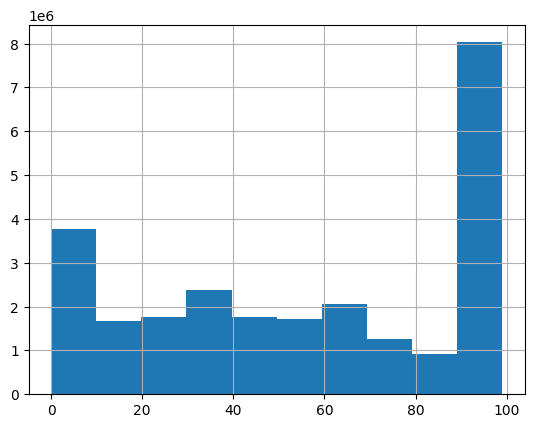

In [41]:
var2['CAR2463.GQ'].hist()

In [30]:
bool({1,2}.intersection({4,3}))

False

### PLAN

1. filter parents genotypes
2. filter children genotypes

In [18]:
variants.head(200000)[variants.head(200000).apply(filter_by_mend_variants, axis=1, proband=proband)]\
    [[mother+'.AD', mother+'.GT', father+'.GT', proband+'.GT']]

,CAR2493_F.AD,CAR2493_F.GT,CAR2494_M.GT,CAR2463.GT
0,"[2, 0]",AT/AT,A/A,A/A
4,"[4, 0]",G/G,G/GA,GA/GA
5,"[3, 0]",A/A,A/T,T/T
14,"[6, 0]",G/G,A/A,A|A
48,"[4, 0]",A/A,A|G,G|G
...,...,...,...,...
220722,"[0, 6]",C|C,G/G,C|C
220723,"[0, 6]",T|T,A/A,T|T
220827,"[2, 0]",A/A,G|G,G|G
220890,"[0, 3]",T|T,C/C,T|T


In [22]:
250/60*30/60

2.0833333333333335

In [26]:
variants.iloc[0][mother+'.GT']

'AT/AT'

In [ ]:
var63flt = var63[
    (var63['CAR2463.GT'] != './.') &
    (var63['CAR2463.DP'] > 10) &
    (var63['CAR2463.GQ'] > 25) &
    (var63['CAR2463.PL'].apply(filter_by_PL)) &
    (var63['CAR2463.AD'].apply(filter_by_only_2_AD))
]
var63flt.shape
# (16721257, 7)

(16672056, 7)

In [53]:
var63.shape

(25376877, 7)

In [18]:
var63['CAR2463.AD'].apply(len).value_counts()

2    23104185
3     1960269
4      224938
5       59999
6       19374
7        8112
Name: CAR2463.AD, dtype: int64

In [17]:
var63flt['CAR2463.AD'].apply(len).value_counts()

2    15732369
3      840646
4       76294
5       16423
6        4579
7        1745
Name: CAR2463.AD, dtype: int64

In [19]:
var63flt[var63flt['CAR2463.AD'].apply(len) > 6]

,CHROM,POS,CAR2463.GT,CAR2463.DP,CAR2463.AD,CAR2463.GQ,CAR2463.PL
440,NC_056572.1,45979,AACAC/AAC,14.0,"[0, 0, 11, 0, 0, 3, 0]",58.0,"[552, 506, 483, 90, 91, 58, 506, 483, 91, 483,..."
6971,NC_056572.1,378264,CAAAA/CAA,15.0,"[0, 0, 5, 10, 0, 0, 0]",99.0,"[659, 582, 549, 329, 322, 285, 156, 152, 0, 10..."
31764,NC_056572.1,1413627,GGTGATCAATCTA/GGTGATCAA,16.0,"[0, 3, 13, 0, 0, 0, 0]",79.0,"[717, 540, 523, 123, 0, 79, 710, 538, 122, 706..."
73937,NC_056572.1,2780973,G/GCACACACACACACA,12.0,"[0, 5, 0, 7, 0, 0, 0]",99.0,"[504, 294, 279, 504, 294, 504, 210, 0, 210, 18..."
74670,NC_056572.1,2797367,TCA/T,14.0,"[0, 7, 7, 0, 0, 0, 0]",99.0,"[625, 262, 223, 256, 0, 216, 576, 257, 251, 55..."
...,...,...,...,...,...,...,...
25335066,NC_056621.1,19763757,T|TGTGC,15.0,"[9, 0, 0, 0, 0, 6, 0]",99.0,"[215, 243, 621, 243, 621, 621, 243, 621, 621, ..."
25348495,NC_056621.1,21203088,ATCTTCTTCTTCTTCTTCTTCTTCTTCTTCTTCT/ATCTTCTTCTT...,17.0,"[17, 0, 0, 0, 0, 0, 0]",27.0,"[0, 27, 405, 27, 405, 405, 27, 405, 405, 405, ..."
25358440,NC_056621.1,22059554,ACTCTAAATGG|AGTGCCGGCGCTGTGGTGGGGCATTCGAGGGCCG...,22.0,"[15, 0, 0, 0, 7, 0, 0]",99.0,"[249, 294, 919, 294, 919, 919, 294, 919, 919, ..."
25358703,NC_056621.1,22093407,T/T,25.0,"[25, 0, 0, 0, 0, 0, 0]",30.0,"[0, 30, 450, 30, 450, 450, 30, 450, 450, 450, ..."


In [59]:
(variants.POS.iloc[1:] - variants.POS.iloc[:-1]).describe()

count    25376875.0
mean            0.0
std             0.0
min             0.0
25%             0.0
50%             0.0
75%             0.0
max             0.0
Name: POS, dtype: float64

In [46]:
var63flt[var63flt['CAR2463.AD'].apply(lambda x: x[0] <= 1)]

,CHROM,POS,CAR2463.GT,CAR2463.DP,CAR2463.AD,CAR2463.GQ,CAR2463.PL
73,NC_056572.1,25480,T|T,15.0,"[0, 15]",45.0,"[664, 45, 0]"
74,NC_056572.1,25482,G|G,15.0,"[0, 15]",45.0,"[664, 45, 0]"
82,NC_056572.1,26129,A/A,15.0,"[0, 15]",45.0,"[537, 45, 0]"
84,NC_056572.1,26434,G/G,15.0,"[0, 15]",45.0,"[561, 45, 0]"
85,NC_056572.1,26472,C/C,14.0,"[0, 14]",42.0,"[524, 42, 0]"
...,...,...,...,...,...,...,...
25376682,NC_056621.1,24417453,C/C,23.0,"[0, 23]",69.0,"[913, 69, 0]"
25376705,NC_056621.1,24420590,T/T,19.0,"[0, 19]",57.0,"[728, 57, 0]"
25376771,NC_056621.1,24425925,C|C,33.0,"[0, 33]",99.0,"[1463, 99, 0]"
25376772,NC_056621.1,24425932,C|C,31.0,"[0, 31]",93.0,"[1382, 93, 0]"


In [39]:
red_var63.shape, var63flt.shape

((26170814, 3), (16815694, 6))

In [23]:
red_var63flt.sample(30)

,CHROM,POS,CAR2463.PL
21073109,NC_056611.1,23933035,"[959, 72, 0, 959, 72, 959]"
23400946,NC_056616.1,8653039,"[0, 45, 675]"
3663794,NC_056578.1,18311579,"[612, 0, 175]"
12038569,NC_056595.1,7226785,"[0, 81, 990]"
19772356,NC_056609.1,4229051,"[0, 120, 1800]"
16031156,NC_056601.1,32136403,"[495, 33, 0]"
9676924,NC_056590.1,2401910,"[395, 0, 263]"
9345507,NC_056589.1,14627568,"[0, 51, 759]"
2142196,NC_056575.1,19537470,"[99, 0, 223]"
4831530,NC_056580.1,4281924,"[0, 21, 236]"


In [22]:
red_var63flt = red_var63[red_var63['CAR2463.PL'].apply(filter_by_PL)]
red_var63flt

,CHROM,POS,CAR2463.PL
1,NC_056572.1,310,"[261, 21, 0]"
6,NC_056572.1,3943,"[105, 0, 285]"
7,NC_056572.1,3959,"[105, 0, 285]"
8,NC_056572.1,3974,"[219, 0, 105]"
17,NC_056572.1,5158,"[360, 27, 0]"
...,...,...,...
26170809,NC_001606.1,16024,"[0, 120, 1634]"
26170810,NC_001606.1,16060,"[0, 120, 1634]"
26170811,NC_001606.1,16081,"[75535, 6188, 0]"
26170812,NC_001606.1,16156,"[0, 120, 1800]"


In [3]:
variants

,CHROM,POS,REF,ALT,QUAL,DP,MQ,AN,hiConfDeNovo,loConfDeNovo,...,CAR2492.AD,CAR2492.GQ,CAR2493_F.GT,CAR2493_F.DP,CAR2493_F.AD,CAR2493_F.GQ,CAR2494_M.GT,CAR2494_M.DP,CAR2494_M.AD,CAR2494_M.GQ
0,NC_056572.1,264,AT,A,601.15,52,54.53,42,None,None,...,"[2, 0]",6.0,AT/AT,2.0,"[2, 0]",0.0,A/A,2.0,"[0, 2]",6.0
1,NC_056572.1,310,A,G,675.38,114,56.31,58,None,None,...,"[5, 0]",15.0,A/A,4.0,"[4, 0]",0.0,A/A,6.0,"[6, 0]",18.0
2,NC_056572.1,410,G,C,954.94,174,58.37,62,None,None,...,"[6, 0]",18.0,G/G,5.0,"[5, 0]",12.0,G/C,13.0,"[8, 5]",99.0
3,NC_056572.1,419,C,T,1135.03,166,58.61,60,None,None,...,"[3, 3]",95.0,C/T,5.0,"[2, 3]",69.0,C/C,13.0,"[13, 0]",39.0
4,NC_056572.1,441,G,GA,1760.66,132,57.73,60,None,None,...,"[2, 2]",49.0,G/G,4.0,"[4, 0]",9.0,G/GA,10.0,"[2, 8]",32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26170669,NC_056621.1,24458059,A,AATCTCGATTGGT,141.96,214,57.95,62,None,CAR2463,...,"[5, 0]",9.0,A/A,6.0,"[6, 0]",9.0,A/A,8.0,"[8, 0]",6.0
26170673,NC_056621.1,24465660,GT,G,533.93,101,59.67,52,None,None,...,"[2, 0]",6.0,GT/GT,5.0,"[5, 0]",15.0,GT/G,11.0,"[4, 7]",99.0
26170674,NC_056621.1,24465661,T,"G,*",618.92,101,59.34,46,None,None,...,"[1, 0, 0]",0.0,T/T,5.0,"[5, 0, 0]",15.0,G/*,11.0,"[0, 4, 7]",99.0
26170675,NC_056621.1,24465729,T,"A,TTTTA",2260.49,113,59.10,44,None,None,...,"[0, 3, 0]",9.0,./.,5.0,"[5, 0, 0]",0.0,A/TTTTA,10.0,"[0, 5, 5]",99.0


In [7]:
variants[variants[samples_lst[0]+'.DP'] > 5][samples_lst[0]+'.AD'].apply(len).value_counts()

2    19888504
3     1372441
4      149755
5       38502
6       11985
7        4607
Name: CAR2463.AD, dtype: int64

In [6]:
chi_ad = pd.DataFrame(variants[variants[samples_lst[0]+'.DP'] > 5][samples_lst[0]+'.AD'].to_list(),
                      columns=['ad_ref', 'ad_alt'])

moz_ad = pd.DataFrame(variants[variants[mother+'.DP'] > 5][mother+'.AD'].to_list(), 
                      columns=['ad_ref', 'ad_alt'])

faz_ad = pd.DataFrame(variants[variants[father+'.DP'] > 5][father+'.AD'].to_list(), 
                      columns=['ad_ref', 'ad_alt'])

ValueError: 2 columns passed, passed data had 7 columns

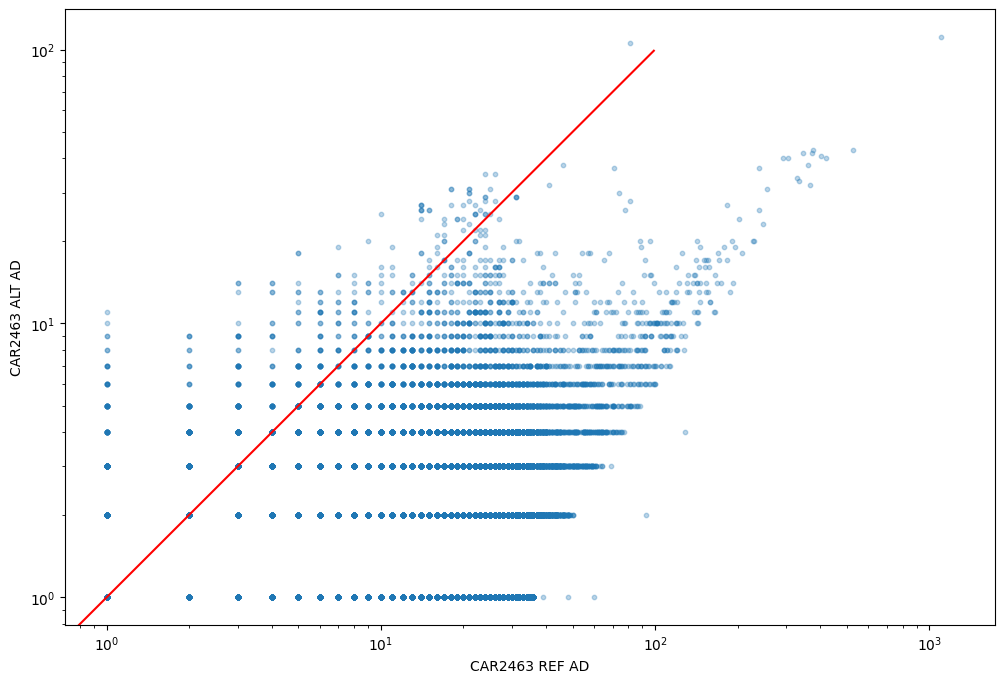

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(chi_ad.ad_ref, chi_ad.ad_alt, alpha=0.3, s=10)
plt.plot(np.arange(100), np.arange(100), 'r')
plt.xlabel('CAR2463 REF AD')
plt.ylabel('CAR2463 ALT AD')

plt.xscale('log')
plt.yscale('log')
plt.show()

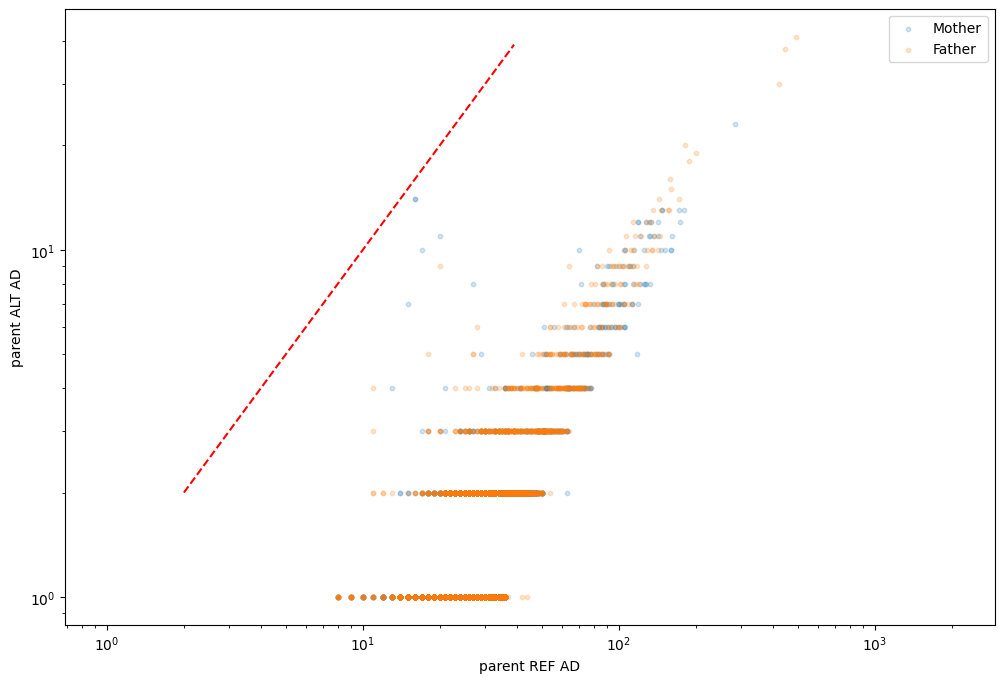

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(moz_ad.ad_ref, moz_ad.ad_alt, label='Mother', alpha=0.2, s=10)
plt.scatter(faz_ad.ad_ref, faz_ad.ad_alt, label='Father', alpha=0.2, s=10)

plt.plot(np.arange(2, 40), np.arange(2, 40), 'r--')

plt.xlabel('parent REF AD')
plt.ylabel('parent ALT AD')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
# variants[(~variants.hiConfDeNovo.isna())]\
#     .to_csv('./data/interim/cor/cohort.merged.table.hidenovo', sep='\t')
# variants[(~variants.hiConfDeNovo.isna())]\
#     .to_parquet('./data/interim/cor/cohort.merged.table.hidenovo.parquet')

In [3]:
variants = pd.read_parquet('./data/interim/cor/cohort.merged.table.hidenovo.parquet')
variants

,CHROM,POS,REF,ALT,QUAL,DP,MQ,AN,hiConfDeNovo,loConfDeNovo,...,CAR2492.AD,CAR2492.GQ,CAR2493_F.GT,CAR2493_F.DP,CAR2493_F.AD,CAR2493_F.GQ,CAR2494_M.GT,CAR2494_M.DP,CAR2494_M.AD,CAR2494_M.GQ
375,NC_056572.1,41100,TA,T,32.39,585,60.00,64,CAR2478,None,...,"[25, 0]",72.0,TA/TA,31.0,"[31, 0]",90.0,TA/TA,31.0,"[31, 0]",81.0
376,NC_056572.1,41102,TA,T,32.39,586,60.00,64,CAR2478,None,...,"[25, 0]",72.0,TA/TA,31.0,"[31, 0]",90.0,TA/TA,31.0,"[31, 0]",81.0
380,NC_056572.1,41845,C,T,107.42,725,60.00,64,CAR2479,None,...,"[31, 0]",90.0,C/C,34.0,"[34, 0]",99.0,C/C,29.0,"[29, 0]",81.0
465,NC_056572.1,46028,T,C,97.71,324,60.00,64,CAR2478,None,...,"[4, 0]",0.0,T/T,10.0,"[10, 0]",30.0,T/T,8.0,"[8, 0]",24.0
504,NC_056572.1,49540,T,A,57.42,322,59.96,62,CAR2480,None,...,"[12, 0]",36.0,T/T,13.0,"[13, 0]",30.0,T|T,10.0,"[10, 0]",30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26170578,NC_056621.1,24429381,T,A,292.85,744,59.68,64,"CAR2474,CAR2488,CAR2491",None,...,"[27, 0]",75.0,T/T,11.0,"[11, 0]",33.0,T/T,30.0,"[30, 0]",48.0
26170579,NC_056621.1,24429391,G,C,295.86,702,59.45,64,"CAR2474,CAR2488,CAR2491",None,...,"[24, 0]",72.0,G/G,10.0,"[10, 0]",30.0,G/G,29.0,"[29, 0]",44.0
26170603,NC_056621.1,24433427,A,G,32.67,618,59.93,64,CAR2474,None,...,"[13, 0]",27.0,A/A,25.0,"[25, 0]",66.0,A/A,22.0,"[22, 0]",57.0
26170605,NC_056621.1,24433516,A,G,32.42,634,59.92,64,CAR2474,None,...,"[20, 0]",60.0,A/A,21.0,"[21, 0]",60.0,A/A,20.0,"[20, 0]",60.0


- **hiConfDeNovo**  Description="High confidence possible de novo mutation (GQ >= 20 for all trio members)=[comma-delimited list of child samples]">
- **loConfDeNovo**  Description="Low confidence possible de novo mutation (GQ >= 10 for child, GQ > 0 for parents)=[comma-delimited list of child samples]">

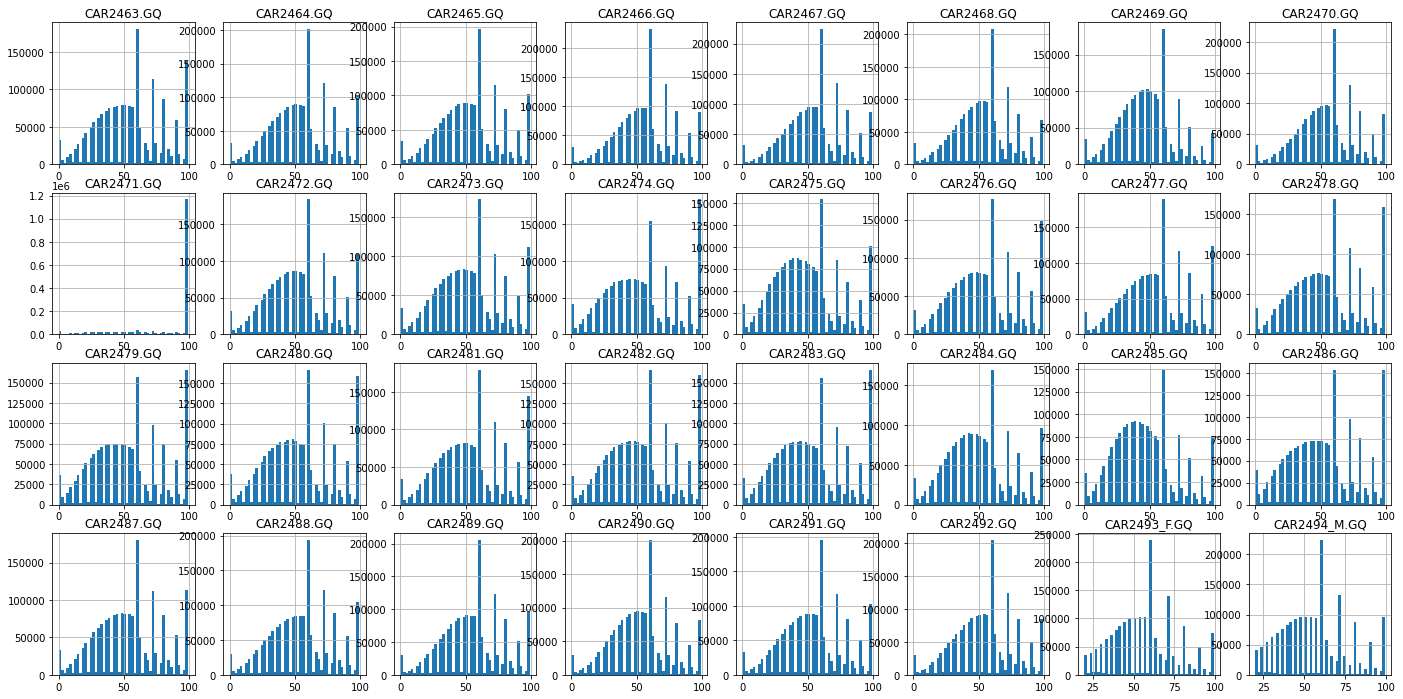

In [8]:
plt.figure(figsize=(24, 12))
for i,s in enumerate([x for x in variants.columns if '.GQ' in x], 1):
    plt.subplot(4, 8, i)
    variants[s][variants[s]<100].hist(bins=50)
    plt.title(s)

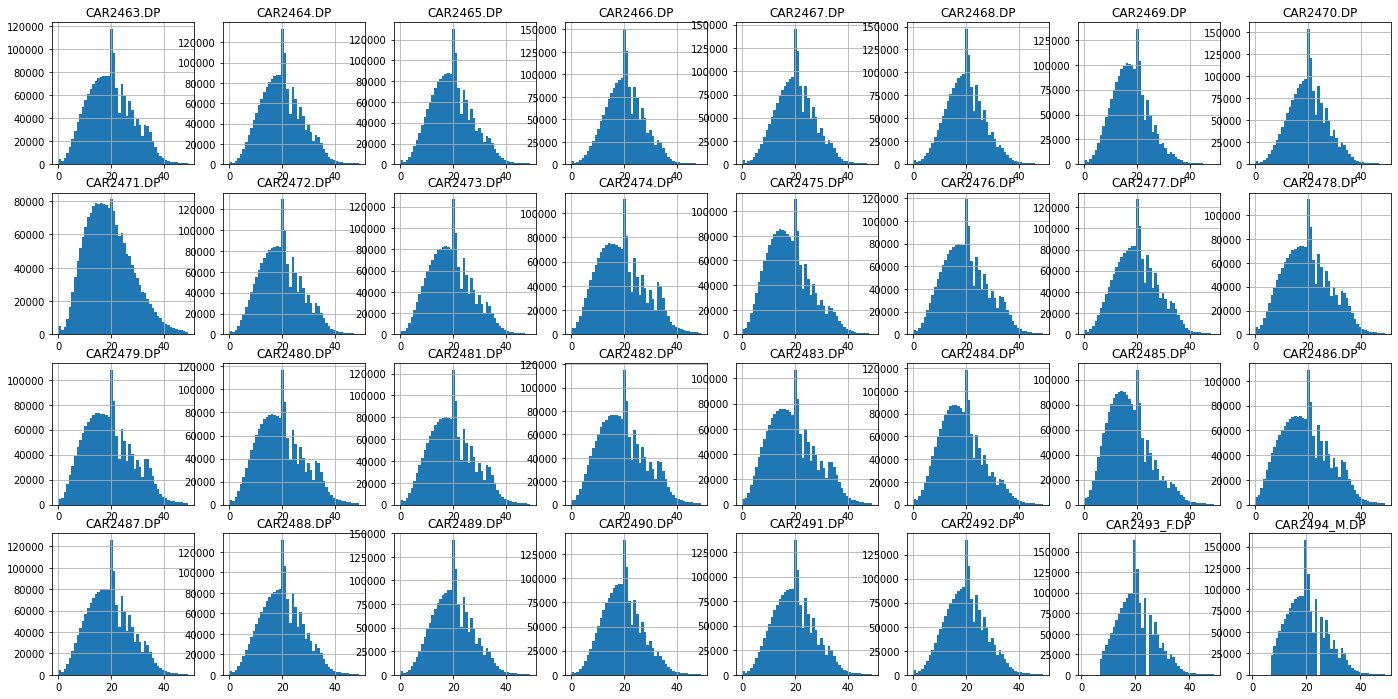

In [9]:
plt.figure(figsize=(24, 12))
for i,s in enumerate([x for x in variants.columns if '.DP' in x], 1):
    plt.subplot(4, 8, i)
    variants[s][variants[s]<50].hist(bins=50)
    plt.title(s)

In [5]:
binomtest(12, 35)

BinomTestResult(k=12, n=35, alternative='two-sided', statistic=0.34285714285714286, pvalue=0.08953107893466952)

In [3]:
binomtest(3, 16)

BinomTestResult(k=3, n=16, alternative='two-sided', statistic=0.1875, pvalue=0.021270751953125)

In [22]:
binomtest(4, 16)

BinomTestResult(k=4, n=16, alternative='two-sided', statistic=0.25, pvalue=0.076812744140625)

<AxesSubplot:xlabel='CHROM'>

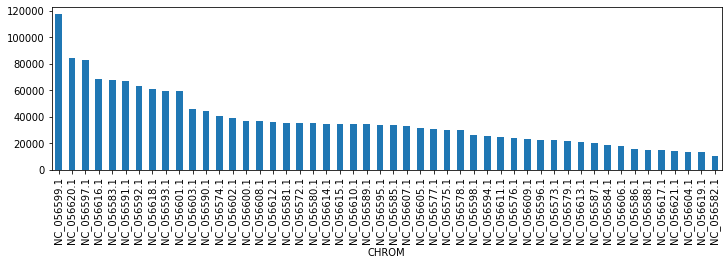

In [6]:
plt.figure(figsize=(12, 3))
variants['CHROM'].value_counts().plot.bar()

Filters:

1. read depth (AD) over 12;
2. Allelic balance between 0.25 and 0.75 - the  fraction  of reads supporting the alternative allele out of the reads supporting the   reference  and alternative allele
3. TODO genotype likelihood difference greater than 20 between the highest and    second-highest scoring genotype (GQ).

https://sciwheel.com/work/item/4248945/resources/10217061/pdf

We extracted de novo candidates from the variants satisfying the following  criteria: 

1. the proband had to be an alternative allele carrier; 
2. **for homozygous alternative allele carriers**, we only considered candidates with ≤   1 read supporting the  reference allele; 
3. minimum depth in the **parent** of **12** reads for the autosomes and 6 reads for hemizygous chromosomes; 
4. maximum of 1 read supporting the alternative allele in the parent; 
5. parent allelic balance <= 0.05;
6. minimum depth of 12 reads for proband;
7. proband allelic balance >= 0.15;
8. maximum of 10 possible and 3 likely carriers beyond the descendants of the parent pair; 
9. maximum of 10% average soft clipping per read covering the DNM candidate. 

In [7]:

# def is_mend_err_by_gt_gatk(ser: pd.Series, proband):
#     # hiConfDeNovo CONTAIN THIS INFO
#     trio = ser.loc[proband+'.GT'], ser.loc[mother+'.GT'], ser.loc[father+'.GT']
#     pgt, mgt, fgt = [set(x.replace('|', '/').split('/')) for x in trio]

#     is_m_child = bool(pgt.difference(mgt))
#     is_f_child = bool(pgt.difference(fgt))

#     return is_m_child or is_f_child

In [4]:
def calc_allele_balance(AD: list):
    """Here we define allelic balance as the   fraction  of reads supporting the alternative allele 
    out of the reads supporting the   reference  and alternative alleles
    """
    assert len(AD) == 2
    ref_support, alt_support = AD

    return alt_support / (ref_support + alt_support)


def estimate_minimal_ad(coverage_median):
    for i in range(1, coverage_median):
        res = binomtest(i, coverage_median)
        if res.pvalue >= 0.05:
            break
    return i

In [5]:
variants[mother+'.AD']

375         [31, 0]
376         [31, 0]
380         [34, 0]
465         [10, 0]
504         [13, 0]
             ...   
26170578    [11, 0]
26170579    [10, 0]
26170603    [25, 0]
26170605    [21, 0]
26170612    [14, 0]
Name: CAR2493_F.AD, Length: 1836936, dtype: object

/tmp/ipykernel_37204/3305958877.py:8: RuntimeWarning: invalid value encountered in long_scalars
  return alt_support / (ref_support + alt_support)


<AxesSubplot:>

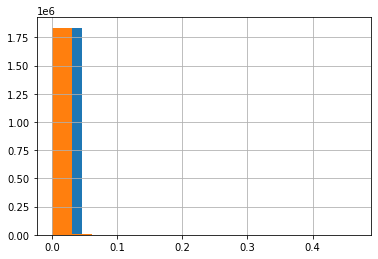

In [14]:
variants[mother+'.AD'].apply(calc_allele_balance).hist()
variants[father+'.AD'].apply(calc_allele_balance).hist()

In [6]:
AD_MIN = 4

In [37]:
# def filter_by_parent(ad: list):
#     minor = min(ad)
#     major = max(ad)

#     if minor <= 1 and major < AD_MIN:
#         return False
#     if minor > 1 and major >= AD_MIN: ????


def filter_by_proband(ad: list):
    minor = min(ad)
    major = max(ad)

    # ab = ad[1] / (minor + major)

    if minor <= 1:
        # homozyg
        if major < AD_MIN:
            return False
    else:
        # heterozyg
        if minor < AD_MIN:
            return False
    
    return True


def is_indel(var: pd.Series):
    ref = var['REF']
    alt = var['ALT'].split(',')
    if '*' in alt:
        return True
    
    if any([len(x) > 1 for x in [ref]+alt]):
        return True
    return False

def is_homozyg(gt: str):
    a, b = gt.replace('|', '/').split('/')
    return a == b

In [8]:
chi_ad = pd.DataFrame(variants[samples_lst[0]+'.AD'].to_list(), columns=['ad_ref', 'ad_alt'])
moz_ad = pd.DataFrame(variants[mother+'.AD'].to_list(), columns=['ad_ref', 'ad_alt'])
faz_ad = pd.DataFrame(variants[father+'.AD'].to_list(), columns=['ad_ref', 'ad_alt'])

In [9]:
variants[samples_lst[0]+'.DP'].quantile(0.99)

44.0

<AxesSubplot:>

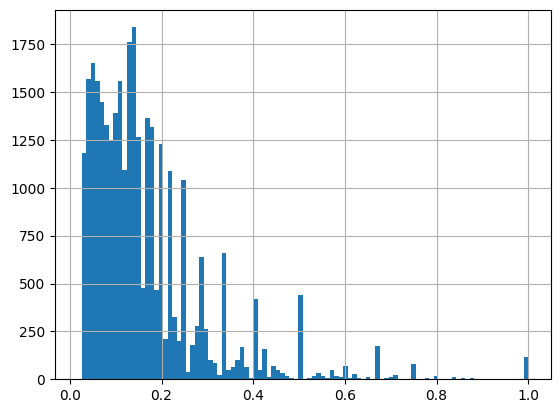

In [10]:
_ = variants[samples_lst[0]+'.AD'].apply(lambda x: x[1] / sum(x))

_[_ > 0].hist(bins=100)

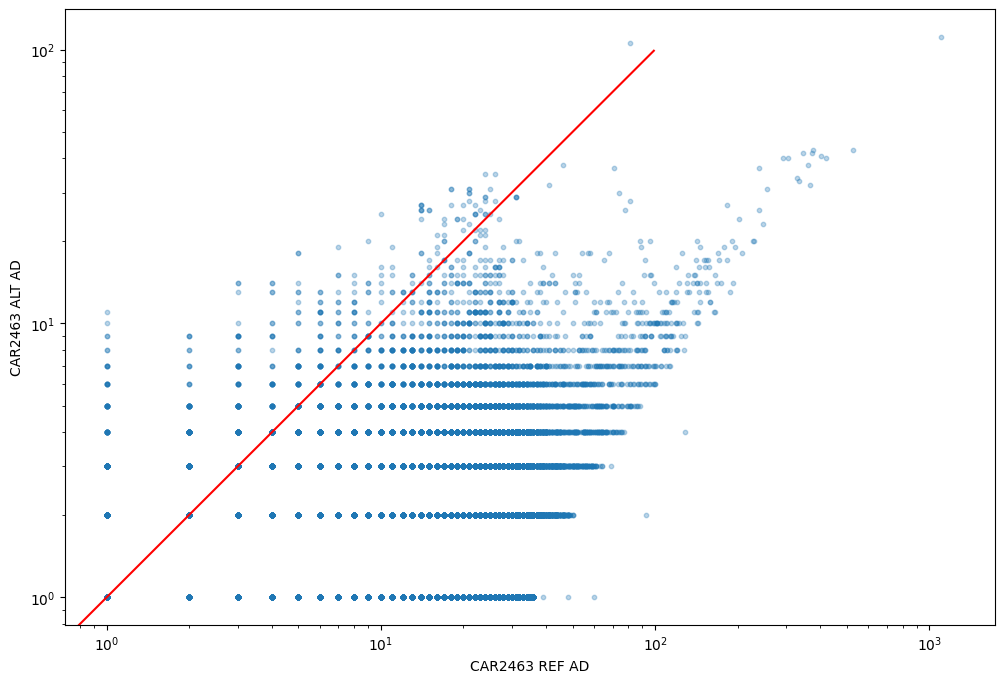

In [28]:
plt.figure(figsize=(12, 8))
plt.scatter(chi_ad.ad_ref, chi_ad.ad_alt, alpha=0.3, s=10)
plt.plot(np.arange(100), np.arange(100), 'r')
plt.xlabel('CAR2463 REF AD')
plt.ylabel('CAR2463 ALT AD')

plt.xscale('log')
plt.yscale('log')
plt.show()

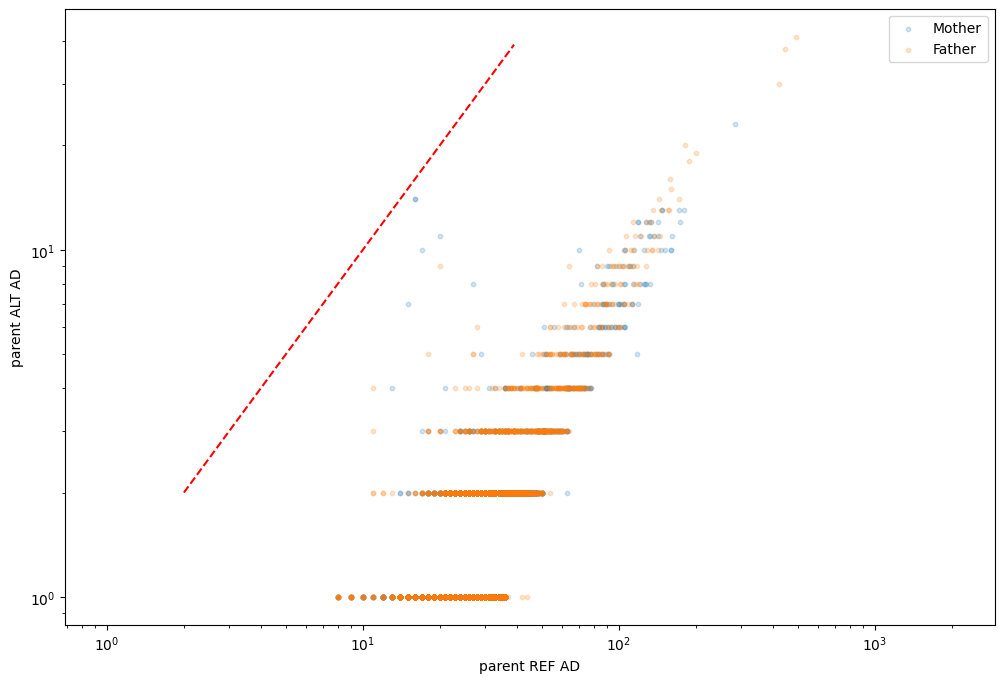

In [26]:
plt.figure(figsize=(12, 8))
plt.scatter(moz_ad.ad_ref, moz_ad.ad_alt, label='Mother', alpha=0.2, s=10)
plt.scatter(faz_ad.ad_ref, faz_ad.ad_alt, label='Father', alpha=0.2, s=10)

plt.plot(np.arange(2, 40), np.arange(2, 40), 'r--')

plt.xlabel('parent REF AD')
plt.ylabel('parent ALT AD')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [13]:
variants[variants.hiConfDeNovo.str.contains(samples_lst[0])][[samples_lst[0]+'.AD', mother+'.AD', father+'.AD']].sample(10)

,CAR2463.AD,CAR2493_F.AD,CAR2494_M.AD
18150779,"[8, 2]","[11, 0]","[14, 0]"
21785230,"[12, 2]","[18, 0]","[16, 0]"
10942866,"[14, 2]","[21, 0]","[34, 0]"
24351862,"[12, 2]","[23, 0]","[38, 0]"
2414724,"[23, 5]","[17, 0]","[16, 0]"
10023473,"[10, 3]","[14, 0]","[25, 0]"
21523242,"[8, 2]","[21, 0]","[25, 0]"
13519036,"[3, 4]","[9, 0]","[13, 0]"
12375048,"[4, 4]","[13, 0]","[7, 0]"
17754048,"[24, 3]","[16, 0]","[23, 1]"


In [29]:
basic_cols = ['CHROM', 'POS', 'REF', 'ALT', 'hiConfDeNovo']
ad_min = estimate_minimal_ad(16) # 4
print(ad_min)

4


In [30]:
chunk = variants#.head(100000)

In [61]:
collected_mend_errs = []

for i, proband in enumerate(samples_lst[:-2], 1):
    fam_cols = []
    for S in [proband, mother, father]:
        for CC in ['GT', 'AD']:
            fam_cols.append(S+'.'+CC)

    cur_df: pd.DataFrame = chunk[basic_cols + fam_cols]

    # must contain ALT allele
    cur_df = cur_df[cur_df[proband+'.AD'].apply(lambda x: x[0] >= 10 and x[1] >= 10)]
    
    # select variatns that has hiConfDeNovo according to GATK 
    cur_df = cur_df[cur_df.hiConfDeNovo.str.contains(proband)]

    # is indel?
    cur_df['indel'] = cur_df.apply(is_indel, axis=1)

    # TODO remove
    cur_df = cur_df[~cur_df.indel]
    
    # calculate allele balance
    # cur_df['proband_ab'] = cur_df[proband+'.AD'].apply(lambda x: x[1] / sum(x))
    # cur_df['mother_ab'] = cur_df[mother+'.AD'].apply(lambda x: x[1] / sum(x))
    # cur_df['father_ab'] = cur_df[father+'.AD'].apply(lambda x: x[1] / sum(x))

    # # is homozyg
    # cur_df['proband_homoz'] = cur_df[proband+'.GT'].apply(is_homozyg)
    # cur_df['mother_homoz'] = cur_df[mother+'.GT'].apply(is_homozyg)
    # cur_df['father_homoz'] = cur_df[father+'.GT'].apply(is_homozyg)

    # cur_df = cur_df[
    #     (cur_df.proband_ab > 0.25) &
    #     (cur_df.mother_ab <= 0.00) &
    #     (cur_df.mother_ab <= 0.00)
    # ]

    
    # 
    # cur_df = cur_df[(cur_df[proband+'.AD'].apply(filter_by_proband)) & \
    #                 (cur_df[mother+'.AD'].apply(filter_by_proband)) & \
    #                 (cur_df[father+'.AD'].apply(filter_by_proband))]

    # cur_df = cur_df[(cur_df[proband+'.GT'] != cur_df[mother+'.GT']) | \
    #                 (cur_df[proband+'.GT'] != cur_df[father+'.GT'])]
    
    # cur_df = cur_df[cur_df.apply(is_mend_err_by_gt_gatk, 1, proband=proband)]

    collected_mend_errs.append(cur_df.copy())

    print(proband, len(cur_df))
    if i % 10 == 0:
        print()
    # break

# cur_df

CAR2463 290
CAR2464 238
CAR2465 251
CAR2466 225
CAR2467 264
CAR2468 252
CAR2469 218
CAR2470 297
CAR2471 327692
CAR2472 251

CAR2473 547
CAR2474 1396
CAR2475 487
CAR2476 608
CAR2477 606
CAR2478 653
CAR2479 597
CAR2480 630
CAR2481 607
CAR2482 783

CAR2483 464
CAR2484 455
CAR2485 372
CAR2486 763
CAR2487 673
CAR2488 430
CAR2489 600
CAR2490 413
CAR2491 581
CAR2492 599



In [66]:
labels = ['ctrl'] * 10 + ['nem-shok'] * 10 + ['nem'] * 10
dnms = pd.DataFrame(list(zip(samples_lst[:-2], [len(x) for x in collected_mend_errs])), 
                    columns=['sample', 'dnm'])
dnms['grp'] = labels
dnms = dnms[dnms['sample'] != 'CAR2471']
dnms

,sample,dnm,grp
0,CAR2463,290,ctrl
1,CAR2464,238,ctrl
2,CAR2465,251,ctrl
3,CAR2466,225,ctrl
4,CAR2467,264,ctrl
5,CAR2468,252,ctrl
6,CAR2469,218,ctrl
7,CAR2470,297,ctrl
9,CAR2472,251,ctrl
10,CAR2473,547,nem-shok


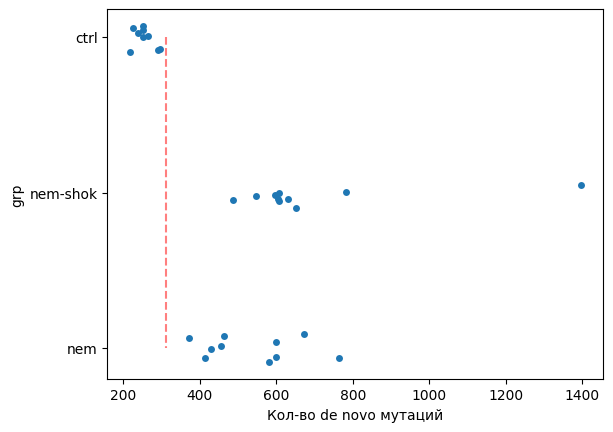

In [73]:
sns.stripplot(dnms, x='dnm', y='grp')

max_ctrl_val = dnms[(dnms['grp'] == 'ctrl')]['dnm'].max()
plt.vlines(max_ctrl_val * 1.05, 0, 2, 'red', 'dashed', '0.02', alpha=0.5,)

plt.xlabel('Кол-во de novo мутаций')
# plt.xscale('log')
# plt.savefig('./figures/dnv_mend_ratio.pdf');
plt.show()

In [158]:
cur_df[cur_df[proband+'.AD'].apply(lambda x: x[1] >= 4)]
# cur_df[[proband+'.GT', proband+'.AD', mother+'.AD', father+'.AD']].sample(10)

,CHROM,POS,REF,ALT,hiConfDeNovo,CAR2463.GT,CAR2463.AD,CAR2493_F.GT,CAR2493_F.AD,CAR2494_M.GT,CAR2494_M.AD,proband_ab,mother_ab,father_ab
18237,NC_056572.1,930320,T,TGAGGGCAGGCGCGC,"CAR2463,CAR2469",T/TGAGGGCAGGCGCGC,"[13, 7]",T/T,"[23, 0]",T/T,"[30, 0]",0.350000,0.0,0.0
25644,NC_056572.1,1185253,ATCTGTTAGCTCTGCAGGAAGTAGAAAGAGG,A,CAR2463,ATCTGTTAGCTCTGCAGGAAGTAGAAAGAGG|A,"[8, 6]",ATCTGTTAGCTCTGCAGGAAGTAGAAAGAGG/ATCTGTTAGCTCTG...,"[12, 0]",ATCTGTTAGCTCTGCAGGAAGTAGAAAGAGG/ATCTGTTAGCTCTG...,"[16, 0]",0.428571,0.0,0.0
25645,NC_056572.1,1185286,C,T,CAR2463,C|T,"[8, 8]",C/C,"[12, 0]",C/C,"[14, 0]",0.500000,0.0,0.0
59735,NC_056572.1,2365286,C,CACGATATATAGCGGCCGATGATTAATGCGCATCTCGCCAGTAAAG...,CAR2463,C|CACGATATATAGCGGCCGATGATTAATGCGCATCTCGCCAGTAA...,"[1, 7]",C|C,"[18, 0]",C/C,"[7, 0]",0.875000,0.0,0.0
80804,NC_056572.1,2939245,CAGTAAA,C,CAR2463,CAGTAAA|C,"[14, 4]",CAGTAAA/CAGTAAA,"[34, 0]",CAGTAAA/CAGTAAA,"[33, 0]",0.222222,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26155957,NC_056621.1,22728145,A,G,"CAR2463,CAR2473",A/G,"[26, 4]",A/A,"[20, 0]",A/A,"[18, 0]",0.133333,0.0,0.0
26164902,NC_056621.1,23679818,CCG,C,CAR2463,CCG|C,"[39, 4]",CCG/CCG,"[26, 0]",CCG/CCG,"[20, 0]",0.093023,0.0,0.0
26164903,NC_056621.1,23679822,T,G,CAR2463,T|G,"[40, 4]",T/T,"[25, 0]",T/T,"[20, 0]",0.090909,0.0,0.0
26164904,NC_056621.1,23679825,C,CGCACTGAG,CAR2463,C|CGCACTGAG,"[39, 4]",C/C,"[27, 0]",C/C,"[20, 0]",0.093023,0.0,0.0


In [196]:
basic_cols = ['CHROM', 'POS', 'REF', 'ALT', 'QUAL', 'DP', 'MQ', 'AN', 'hiConfDeNovo']

def process_chunk(chunk: pd.DataFrame):
    collected_mend_errs = []
    
    ad_min = estimate_minimal_ad(16) # 4

    for proband in samples_lst[:-2]:
        fam_cols = [c for c in chunk.columns if proband in c or mother in c or father in c]
        
        cur_df: pd.DataFrame = chunk[basic_cols + fam_cols]
        
        cur_df = cur_df[cur_df.hiConfDeNovo.str.contains(proband)]
        
        cur_df['allele_balance'] = cur_df[proband+'.AD'].apply(calc_allele_balance)
        
        cur_df = cur_df[(cur_df[proband+'.AD'].apply(min) >= ad_min) & \
                        (cur_df[mother+'.AD'].apply(min)  >= ad_min) & \
                        (cur_df[father+'.AD'].apply(min)  >= ad_min)]
        # cur_df = cur_df[(cur_df[proband+'.GT'] != cur_df[mother+'.GT']) | \
        #                 (cur_df[proband+'.GT'] != cur_df[father+'.GT'])]
        
        # cur_df = cur_df[cur_df.apply(is_mend_err_by_gt_gatk, 1, proband=proband)]

        collected_mend_errs.append(cur_df.copy())
        
    return collected_mend_errs


def split_dataframe(df, n_chunks):
    chunk_size = int(np.ceil(len(df) / n_chunks))
    return [df.iloc[i:i + chunk_size] for i in range(0, len(df), chunk_size)]

In [24]:
# n_chunks = 32
# chunks = split_dataframe(variants, n_chunks)
# assert sum([len(x) for x in chunks]) == len(variants)

# # 15min
# with Pool(n_chunks) as pool:
#     results = pool.map(process_chunk, chunks)

# for i, smpl in enumerate(samples_lst[:-2]):
#     print(i, smpl)

#     smpl_df = pd.concat([x[i] for x in results]).assign(PROBAND=smpl)
#     smpl_df.to_csv(f'./data/interim/mend_errors_gatk/{smpl}.csv', index=False)

In [69]:
# number of pre-DNM variants shared between samples
(variants.hiConfDeNovo.str.count(',')+1).value_counts()

1    1656646
2     132316
3      47974
Name: hiConfDeNovo, dtype: int64

In [197]:
collected_mend_errs = process_chunk(variants.head(10000))
collected_mend_errs[0]

CAR2463 14.0 3
CAR2464 12.0 3
CAR2465 14.0 3
CAR2466 13.5 3
CAR2467 14.0 3
CAR2468 12.0 3
CAR2469 14.0 3
CAR2470 14.0 3
CAR2471 16.0 4
CAR2472 13.0 3
CAR2473 12.0 3
CAR2474 15.0 4
CAR2475 11.0 2
CAR2476 15.0 4
CAR2477 14.0 3
CAR2478 13.0 3
CAR2479 14.0 3
CAR2480 14.0 3
CAR2481 13.0 3
CAR2482 13.0 3
CAR2483 14.0 3
CAR2484 13.0 3
CAR2485 13.0 3
CAR2486 14.0 3
CAR2487 12.0 3
CAR2488 14.0 3
CAR2489 14.0 3
CAR2490 13.0 3
CAR2491 14.0 3
CAR2492 14.0 3


,CHROM,POS,REF,ALT,QUAL,DP,MQ,AN,hiConfDeNovo,CAR2463.GT,...,CAR2463.AD,CAR2463.GQ,CAR2493_F.GT,CAR2493_F.DP,CAR2493_F.AD,CAR2493_F.GQ,CAR2494_M.GT,CAR2494_M.DP,CAR2494_M.AD,CAR2494_M.GQ
6033,NC_056572.1,326529,G,T,53.42,675,59.94,64,"CAR2463,CAR2474",G|T,...,"[10, 2]",54.0,G/G,23.0,"[23, 0]",60.0,G/G,20.0,"[20, 0]",60.0
6034,NC_056572.1,326531,G,A,38.67,676,59.92,64,CAR2463,G|A,...,"[10, 2]",54.0,G/G,22.0,"[22, 0]",57.0,G/G,20.0,"[20, 0]",60.0
9632,NC_056572.1,506932,GT,G,57.16,958,60.00,64,"CAR2463,CAR2471",GT/G,...,"[14, 3]",34.0,GT/GT,39.0,"[39, 0]",90.0,GT/GT,32.0,"[30, 2]",40.0
9717,NC_056572.1,511689,ATT,A,119.13,462,60.00,64,"CAR2463,CAR2491",ATT|A,...,"[11, 2]",51.0,ATT/ATT,21.0,"[21, 0]",63.0,ATT/ATT,16.0,"[16, 0]",45.0
9719,NC_056572.1,511695,G,T,126.60,464,60.00,60,"CAR2463,CAR2491",G|T,...,"[11, 2]",51.0,G/G,20.0,"[20, 0]",60.0,G/G,16.0,"[16, 0]",45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260969,NC_056572.1,12444520,ATTTAGCTGCTGCCATCTGTGTC,A,46.01,653,59.99,64,"CAR2463,CAR2488",ATTTAGCTGCTGCCATCTGTGTC|A,...,"[15, 2]",39.0,ATTTAGCTGCTGCCATCTGTGTC/ATTTAGCTGCTGCCATCTGTGTC,24.0,"[24, 0]",72.0,ATTTAGCTGCTGCCATCTGTGTC|ATTTAGCTGCTGCCATCTGTGTC,18.0,"[18, 0]",53.0
275326,NC_056572.1,13209326,A,T,74.47,429,59.25,64,CAR2463,A|T,...,"[11, 3]",90.0,A/A,19.0,"[19, 0]",57.0,A/A,21.0,"[21, 0]",60.0
286458,NC_056572.1,13771343,T,TAAAAC,68.45,751,59.90,64,CAR2463,T|TAAAAC,...,"[14, 3]",84.0,T/T,17.0,"[17, 0]",48.0,T/T,39.0,"[18, 0]",99.0
288163,NC_056572.1,13818909,A,AAAAGTCGAGAACCCTGGTTCTGAGTCC,58.64,635,59.77,64,"CAR2463,CAR2472",A|AAAAGTCGAGAACCCTGGTTCTGAGTCC,...,"[13, 2]",45.0,A/A,19.0,"[19, 0]",45.0,A/A,27.0,"[27, 0]",48.0


In [137]:
collected_mend_errs[1]['CAR2464.DP'].describe()

count    12924.000000
mean        23.309115
std         17.443268
min         12.000000
25%         15.000000
50%         20.000000
75%         27.000000
max        777.000000
Name: CAR2464.DP, dtype: float64

In [96]:
for i, smpl in enumerate(samples_lst[:-2]):

    smpl_df = collected_mend_errs[i].assign(PROBAND=smpl)
    print(i, smpl, len(smpl_df))
    smpl_df.to_csv(f'./data/interim/mend_errors_gatk/{smpl}.csv', index=False)

0 CAR2463 11858
1 CAR2464 12924
2 CAR2465 12175
3 CAR2466 12366
4 CAR2467 12027
5 CAR2468 10049
6 CAR2469 9363
7 CAR2470 14018
8 CAR2471 972397
9 CAR2472 15428
10 CAR2473 18517
11 CAR2474 46705
12 CAR2475 9672
13 CAR2476 11431
14 CAR2477 12295
15 CAR2478 11047
16 CAR2479 18485
17 CAR2480 23562
18 CAR2481 17488
19 CAR2482 19708
20 CAR2483 12893
21 CAR2484 10379
22 CAR2485 10138
23 CAR2486 19657
24 CAR2487 15991
25 CAR2488 12405
26 CAR2489 14957
27 CAR2490 11489
28 CAR2491 18922
29 CAR2492 10836
